# Advanced Computational Methods in Statistics
### Gerardo Durán-Martín

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(precision=5, suppress=True)

$$
\begin{aligned}
    X_n &= \rho X_{n-1} + \tau V_n\\
    Y_n &= X_n + \sigma W_n
\end{aligned}
$$
with

* $V_n, W_n \sim \mathcal{N}(0, 1)$
* $X_0 \sim \mathcal{N}(0, 1)$

In [3]:
@dataclass
class SSM:
    rho: float
    tau: float
    sigma: float
    n_particles: int

ssm = SSM(rho=0.8, tau=1, sigma=0.1, n_particles=100)

In [4]:
def sample_step(x_prev, key, ssm):
    latent_noise, obs_noise = jax.random.normal(key, (2,))
    
    x_next = ssm.rho * x_prev + ssm.tau * latent_noise
    y_next = x_next + ssm.sigma * obs_noise
    
    state = {"x": x_next, "y": y_next}
    return x_next, state

In [5]:
num_timesteps  = 500
key = jax.random.PRNGKey(314)
key_init, *key_steps = jax.random.split(key, num_timesteps + 1)
key_steps = jnp.r_[key_steps]

x_init = jax.random.normal(key_init)

sample_step_part = partial(sample_step, ssm=ssm)

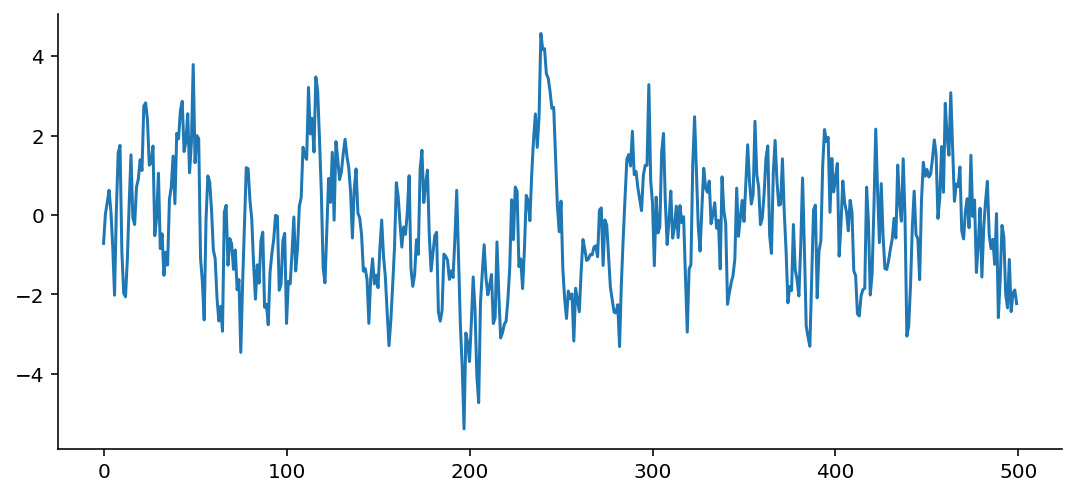

In [294]:
_, hist = jax.lax.scan(sample_step_part, x_init, key_steps)
y_obs = hist["y"]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(y_obs)

## Kalman filter

We perfom Kalman filter to compare against our estimated posteriors using particle filtering

In [295]:
# from jsl.nlds.sequential_monte_carlo import NonMarkovianSequenceModel
from jsl.lds.kalman_filter import LDS, filter

lds = LDS(jnp.array([[ssm.rho]]), jnp.array([1.0]),
          jnp.array([[ssm.tau]]) ** 2, jnp.array([[ssm.sigma]]) ** 2,
          jnp.array([0.0]), jnp.array([[1.0]]))

expected_value_kf, covariance_kf, marg_mean, marg_var = filter(lds, hist["y"][:, None])

expected_value_kf = expected_value_kf.ravel()
covariance_kf = covariance_kf.ravel()

marg_mean = marg_mean.ravel()
marg_var = marg_var.ravel()

# Importance Sampling (IS)

In [14]:
from jax.scipy import stats
from functools import partial

In [17]:
@dataclass
class SSMConfig:
    rho: float
    tau: float
    sigma: float
    n_particles: int


def sis_step(state, xs, config):
    log_w_prev, x_prev = state
    key, y = xs
    
    x_next = config.rho * x_prev + jax.random.normal(key, (config.n_particles,)) * config.tau
    log_w_next = log_w_prev + stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next
    }
    
    return (log_w_next, x_next), carry


def sis_lssm(key, observations, ssm_config):
    """
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    keys_step = jax.random.split(key, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (log_w_init, x_init)
    input_vals = (keys_step, observations)
    
    sis_step_apply = partial(sis_step, config=ssm_config)
    _, res = jax.lax.scan(sis_step_apply, init_state, input_vals)
    
    weights = jnp.exp(res["log_weights"] - jax.nn.logsumexp(res["log_weights"], axis=1, keepdims=True))
    res["weights"] = weights
    
    return res

In [131]:
ssm_config = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=100_000)

In [132]:
sis_res = sis_lssm(key, hist["x"], ssm_config)
expected_value_sis = jnp.einsum("tn,tn->t", sis_res["particles"], sis_res["weights"])

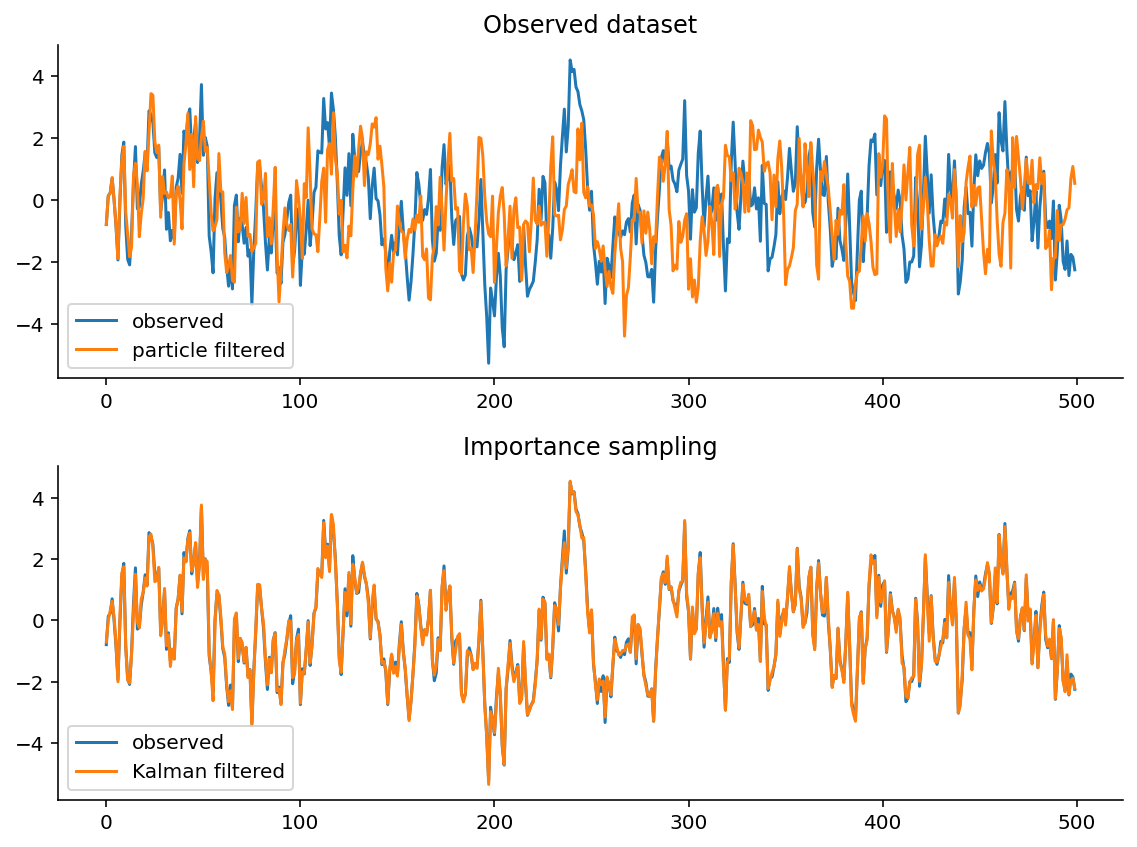

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(hist["x"], label="observed")
ax[0].plot(expected_value_sis, label="particle filtered")

ax[1].plot(hist["x"], label="observed")
ax[1].plot(expected_value_kf, label="Kalman filtered")

ax[0].set_title("Observed dataset")
ax[1].set_title("Importance sampling")

ax[0].legend()
ax[1].legend()
plt.tight_layout()

# Sequential Monte Carlo

In [168]:
def smc_step(state, xs, config):
    w_prev, log_w_prev, x_prev = state
    key, y = xs
    key_resampling, key_proposal = jax.random.split(key)
    
    # Resampling
    x_prev= jax.random.choice(key_resampling, x_prev, shape=(config.n_particles,), p=w_prev)
    
    x_next = config.rho * x_prev + jax.random.normal(key_proposal, (config.n_particles,)) * config.tau
    log_w_next = log_w_prev + stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    w_next = jnp.exp(log_w_next - jax.nn.logsumexp(log_w_next))
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next,
        "weights": w_next,
    }
    
    return (w_next, log_w_next, x_next), carry


def smc_lssm(key, observations, ssm_config):
    """
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    keys_step = jax.random.split(key, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    w_init = jnp.exp(log_w_init)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (w_init, log_w_init, x_init)
    input_vals = (keys_step, observations)
    
    smc_step_apply = partial(smc_step, config=ssm_config)
    _, res = jax.lax.scan(smc_step_apply, init_state, input_vals)
        
    return res

In [268]:
ssm_config = SSMConfig(rho=0.8, tau=1.0, sigma=0.1, n_particles=1000)

In [269]:
key = jax.random.PRNGKey(314)
smc_res = smc_lssm(key, hist["y"], ssm_config)

expected_value_smc = jnp.einsum("tn,tn->t", smc_res["particles"], smc_res["weights"]).block_until_ready()

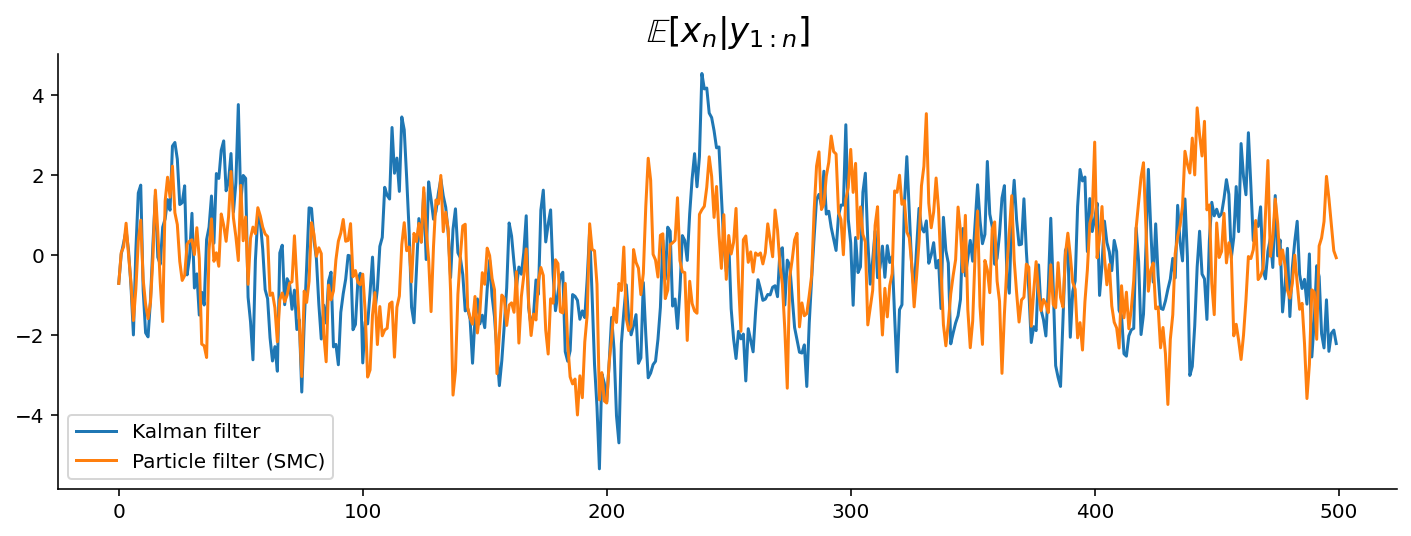

In [270]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(hist["x"], label="observed")

ax.plot(expected_value_kf, label="Kalman filter")
ax.plot(expected_value_smc, label="Particle filter (SMC)")
plt.legend()
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$", fontsize=17);

In [271]:
expected_value_squared_smc = jnp.einsum("tn,tn->t", smc_res["particles"] ** 2, smc_res["weights"]).block_until_ready()
expected_value_squared_kf = covariance_kf + expected_value_kf ** 2

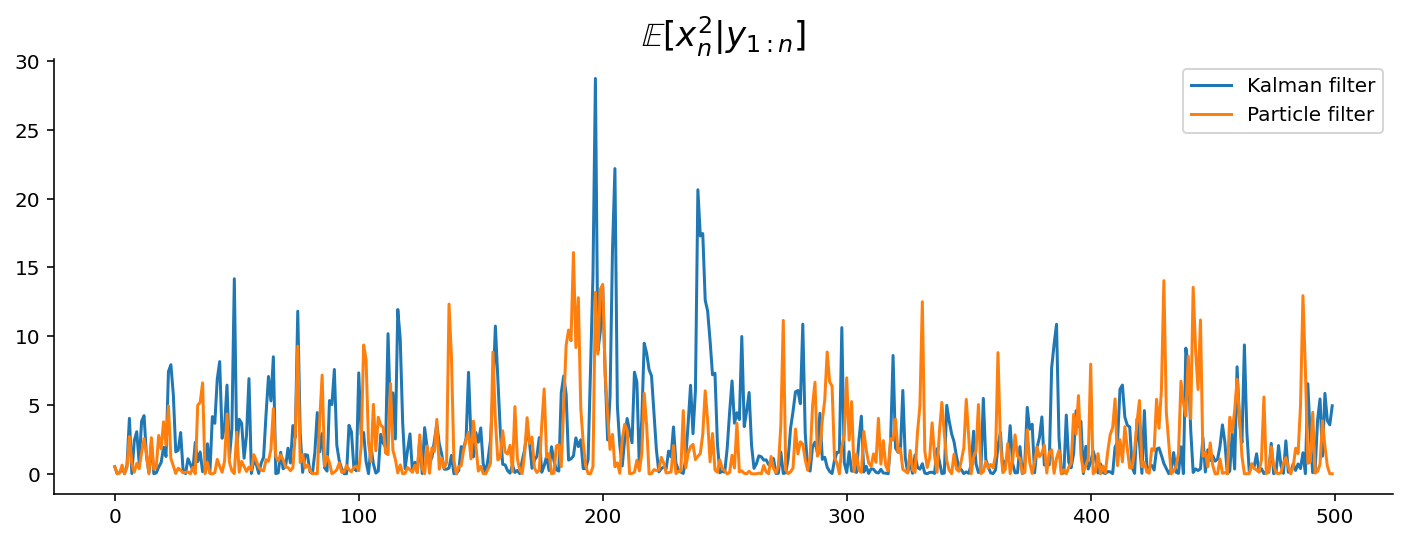

In [272]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(expected_value_squared_kf, label="Kalman filter")
ax.plot(expected_value_squared_smc, label="Particle filter")
ax.legend()
plt.title(r"$\mathbb{E}[x_n^2 \vert y_{1:n}]$", fontsize=17);

## Computing marginal probablity

$$
\begin{aligned}
p(y_{1:t}) &= \int p(y_{1:t}, x_t) dx_t\\
           &= \int p(y_t, y_{1:t-1}, x_t) dx_t
\end{aligned}
$$

In [273]:
hist["y"].shape

(500,)

In [275]:
smc_res.keys()

dict_keys(['log_weights', 'particles', 'weights'])

In [276]:
smc_res["weights"].shape

(500, 1000)

In [277]:
y_marginal.shape

(500,)

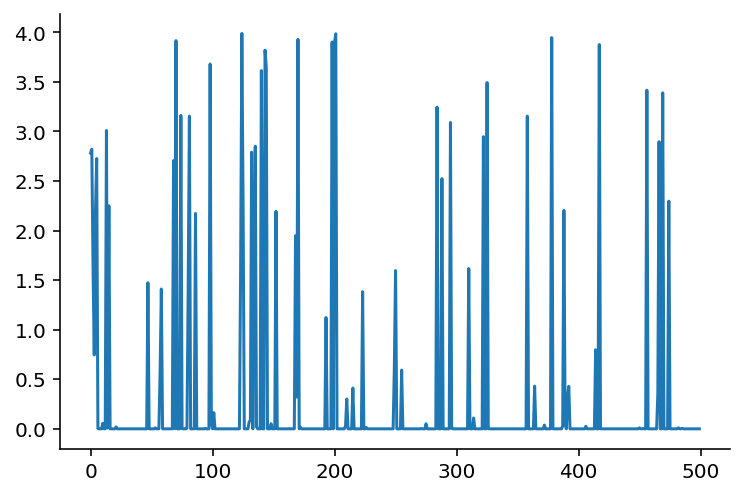

In [278]:
y_marginal = stats.norm.pdf(hist["y"][:, None], smc_res["particles"], scale=ssm_config.sigma)
y_marginal = jnp.einsum("tn,tn->t", smc_res["weights"], y_marginal, precision=jax.lax.Precision.HIGHEST)
plt.plot(y_marginal)

In [333]:
log_terms = smc_res["log_weights"] - (y_obs[:, None] - smc_res["particles"]) ** 2 / (2 * ssm_config.sigma ** 2)

In [334]:
b_scale = 1 / jnp.sqrt(2 * jnp.pi * ssm_config.sigma ** 2)
jax.nn.logsumexp(log_terms, axis=1, b=b_scale)[:50]

DeviceArray([    6.59313,     5.77298,     3.02046,     1.14881,
                -3.31855,    -2.12393,   -14.31294,  -106.36767,
              -246.9427 ,  -290.71664,  -282.43936,  -329.0351 ,
              -322.7325 ,  -311.3068 ,  -322.2058 ,  -315.68542,
              -355.1924 ,  -353.996  ,  -797.53766,  -641.7298 ,
              -661.3334 ,  -655.21326,  -675.6018 ,  -972.03784,
             -1083.7725 , -1149.2623 , -1427.5658 , -1636.1825 ,
             -1550.7998 , -1534.9796 , -1570.8605 , -1619.1604 ,
             -1714.7146 , -1850.7294 , -1916.4781 , -1934.025  ,
             -2471.0547 , -2421.7417 , -2444.381  , -2445.832  ,
             -3089.2717 , -3372.5945 , -3386.904  , -3706.6003 ,
             -3638.584  , -3638.5059 , -3618.0588 , -3608.061  ,
             -3789.6357 , -5240.5845 ], dtype=float32)

In [310]:
jnp.log(stats.norm.pdf(y_obs, marg_mean, marg_var + ssm_config.sigma**2))[:50]

DeviceArray([-1.514  , -1.10355, -0.97739, -1.00449, -1.00936, -1.29908,
             -1.88531, -2.38287, -1.99247, -1.06193, -3.50392, -1.7021 ,
             -1.05418, -1.06842, -1.61025, -1.7509 , -1.71737, -0.9535 ,
             -1.32145, -0.99445, -1.15177, -0.93525, -2.58718, -1.13421,
             -0.94549, -1.14797, -0.97905, -1.16643, -2.6907 , -0.99134,
             -1.52392, -2.29942, -0.95255, -1.56345, -0.97104, -1.06149,
             -1.88427, -1.00927, -1.35322, -1.32386, -2.53912, -0.9752 ,
             -1.52106, -1.2189 , -1.1628 , -1.09182, -1.48997, -1.3878 ,
             -1.37629, -3.59557], dtype=float32)